In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import math
import sklearn
import sklearn.datasets
import h5py
from PIL import Image
from scipy import ndimage
import copy


from nn_building_blocks import *

%matplotlib inline

In [3]:
def model(X, Y, layers_dims, 
                        optimizer="gd", learning_rate = 0.0007, num_epochs = 5000,
                        momentum_beta = 0.9, adam_beta1 = 0.9, adam_beta2 = 0.999,  epsilon = 1e-8,
                        init="random", hidden_activation="relu", output_activation="sigmoid",
                        lambd=0, keep_probs=1, mini_batch_size = None,
                        decay=None, decay_rate=1, 
                        print_cost = False, seed=None, check_gradient=False):

    assert(lambd ==0 or keep_probs==1)
    if seed is not None:
        np.random.seed(seed)

    
    L = len(layers_dims)             
    costs = []                       
    t = 0                            
    m = X.shape[1]                  
    lr_rates = []
    learning_rate0 = learning_rate
    batch_seed = 10
    
    
    
    if init == "random":
        parameters = initialize_parameters(layers_dims, seed)
    elif init == "he":
        parameters = initialize_parameters_he(layers_dims, seed)
    elif init == "xavier":
        parameters = initialize_parameters_xavier(layers_dims, seed)

    
    
    if optimizer != "momentum" and optimizer != "adam":
        pass 
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)

    if mini_batch_size is not None:
        for i in range(num_epochs):
            
            batch_seed = batch_seed + 1
            minibatches = random_mini_batches(X, Y, mini_batch_size, batch_seed)
            cost_total = 0

            for k, minibatch in enumerate(minibatches):
                
                (minibatch_X, minibatch_Y) = minibatch
                
                if keep_probs == 1:
                    al, caches = forward_propagation(minibatch_X, parameters, hidden_activation, output_activation)
                elif keep_probs < 1:
                    al, caches = forward_propagation_with_dropout(minibatch_X, parameters, hidden_activation, output_activation, keep_probs)
                
                if lambd == 0:
                    cost_total += compute_batch_cost(al, minibatch_Y)
                elif lambd > 0:
                    cost_total += compute_batch_cost_regularization(al, minibatch_Y, parameters, lambd)
        
                if lambd >= 0 and keep_probs == 1:
                    grads = backward_propagation(minibatch_X, minibatch_Y, caches, hidden_activation, lambd)
                elif keep_probs < 1:
                    grads = backward_propagation_with_dropout(minibatch_X, minibatch_Y, caches, keep_probs, al, hidden_activation)
                

                if check_gradient and (i % 1000 == 0 or i==num_epochs-1) and k == 0:
                    difference = gradient_checking(parameters, grads, minibatch_X, minibatch_Y, 1e-7, False, hidden_activation, output_activation)
                    print(f"Gradient check difference for minibatch {k} is {difference}")
                
                    
                if optimizer != "momentum" and optimizer != "adam":
                    parameters = update_parameters(parameters, grads, learning_rate)
                elif optimizer == "momentum":
                    parameters, v = update_parameters_with_momentum(parameters, grads, v, momentum_beta, learning_rate)
                elif optimizer == "adam":
                    t = t + 1 # Adam counter
                    parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s,
                                                                   t, learning_rate, adam_beta1, adam_beta2,  epsilon)
        
                    
            if decay:
                learning_rate = decay(learning_rate0, i, decay_rate)

            cost_avg = cost_total / m
            if print_cost and (i % 1000 == 0 or i==num_epochs-1):
                print ("Cost after epoch %i: %f" %(i, cost_avg))
                if decay:
                    print("learning rate after epoch %i: %f"%(i, learning_rate))
                    
            if print_cost and i % 100 == 0:
                costs.append(cost_avg)

    
    else:
        for i in range(num_epochs):
            if keep_probs == 1:
                al, caches = forward_propagation(X, parameters, hidden_activation, output_activation)
            elif keep_probs < 1:
                al, caches = forward_propagation_with_dropout(X, parameters, hidden_activation, output_activation, keep_probs)
            
            if lambd == 0:
                cost_avg = compute_cost_log_loss(al, Y)
            elif lambd > 0:
                cost_avg = compute_cost_with_regularization(al, Y, parameters, lambd)
    
            if lambd >= 0 and keep_probs == 1:
                grads = backward_propagation(X, Y, caches, hidden_activation, lambd)
            elif keep_probs < 1:
                grads = backward_propagation_with_dropout(X, Y, caches, keep_probs, al, hidden_activation)    
        
            if optimizer != "momentum" and optimizer != "adam":
                parameters = update_parameters(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, momentum_beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, adam_beta1, adam_beta2,  epsilon)
    
                
            if decay:
                learning_rate = decay(learning_rate0, i, decay_rate)

            if check_gradient and (i % 1000 == 0 or i==num_epochs-1):
                difference = gradient_checking(parameters, grads, X, Y, 1e-7, False, hidden_activation, output_activation)
                print(f"Gradient check difference: {difference}")

                
            if print_cost and (i % 1000 == 0 or i==num_epochs-1):
                print ("Cost after epoch %i: %f" %(i, cost_avg))
                if decay:
                    print("learning rate after epoch %i: %f"%(i, learning_rate))
            if print_cost and i % 100 == 0:
                costs.append(cost_avg)

            
    # # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("model Learning rate = " + str(learning_rate))
    plt.show()

    # Parameters for prediction and grads for gradient checking
    return parameters, grads

# Binary Classification with Tanh in a Single Hidden Layer NN

In [4]:
np.random.seed(1)
m = 400 # number of examples
N = int(m/2) # number of points per class
D = 2 # dimensionality
X = np.zeros((m,D)) # data matrix where each row is a single example
Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
a = 4 # maximum ray of the flower

for j in range(2):
    ix = range(N*j,N*(j+1))
    t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
    r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    Y[ix] = j
    
X = X.T
Y = Y.T

In [5]:
binary_classification_layers_dims = (X.shape[0], 4, 1)

In [6]:
def binary_1L_model(X, Y, layers_dims, optimizer="gd", learning_rate = 0.0007, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 5000, print_cost = False, decay=None, decay_rate=1):

    np.random.seed(3)
    
    L = len(layers_dims)             
    costs = []                       
    t = 0                            
    m = X.shape[1]                  
    lr_rates = []
    learning_rate0 = learning_rate
    
    parameters = initialize_parameters(layers_dims)

    if optimizer != "momentum" and optimizer != "adam":
        pass 
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)

    
    for i in range(num_epochs):
        al, caches = forward_propagation(X, parameters, "tanh")
        cost_avg = compute_cost_log_loss(al, Y)
        grads = backward_propagation(X, Y, caches, "tanh")

    
        if optimizer != "momentum" and optimizer != "adam":
            parameters = update_parameters(parameters, grads, learning_rate)
        elif optimizer == "momentum":
            parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
        elif optimizer == "adam":
            t = t + 1 # Adam counter
            parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s,
                                                           t, learning_rate, beta1, beta2,  epsilon)

            
        if decay:
            learning_rate = decay(learning_rate0, i, decay_rate)
       
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
            if decay:
                print("learning rate after epoch %i: %f"%(i, learning_rate))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("model Learning rate = " + str(learning_rate))
    plt.show()

    # Parameters for prediction and grads for gradient checking
    return parameters, grads

In [7]:
def predict1(parameters, X):
    A2, cache = forward_propagation(X, parameters, "tanh")
    prediction = (A2 > 0.5).astype(int)
    return prediction

In [8]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)

In [9]:
def load_extra_datasets():  
    N = 200
    noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
    noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)
    blobs = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    no_structure = np.random.rand(N, 2), np.random.rand(N, 2)
    
    return noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure

Gradient check difference: 0.11346765237897169
Cost after epoch 0: 0.693117
Gradient check difference: 0.00038483983761235837
Cost after epoch 1000: 0.281237
Gradient check difference: 0.00014032230124944015
Cost after epoch 2000: 0.268934
Gradient check difference: 0.00010915241592019819
Cost after epoch 3000: 0.261963
Gradient check difference: 9.407476848963222e-05
Cost after epoch 4000: 0.257408
Gradient check difference: 8.186529908874322e-05
Cost after epoch 5000: 0.254261
Gradient check difference: 7.199908762879604e-05
Cost after epoch 6000: 0.251984
Gradient check difference: 6.398245672976433e-05
Cost after epoch 7000: 0.250272
Gradient check difference: 5.7445138583796467e-05
Cost after epoch 8000: 0.248945
Gradient check difference: 5.189234347446078e-05
Cost after epoch 9000: 0.247890
Gradient check difference: 4.7148042465963725e-05
Cost after epoch 9999: 0.247032


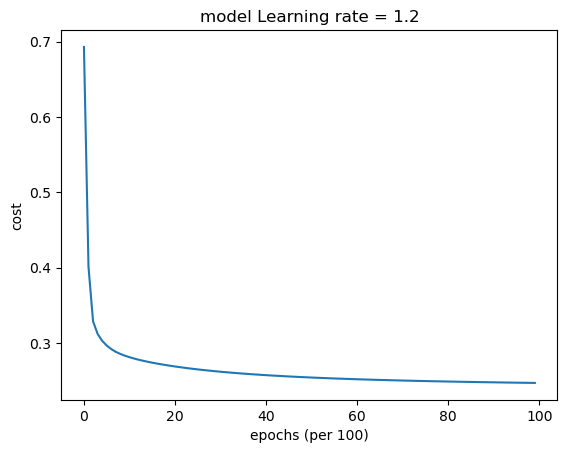

In [10]:
binary_parameters, gradients = model(X, Y, binary_classification_layers_dims, hidden_activation="tanh", optimizer = "gd", learning_rate = 1.2, num_epochs=10000, print_cost=True, check_gradient=True, seed=1)

# Predict
predictions = predict1(binary_parameters, X)

In [11]:
predictions = predict1(binary_parameters, X)
print ('Accuracy: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')

Accuracy: 91%


/tmp/ipykernel_2631/3692857497.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print ('Accuracy: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')


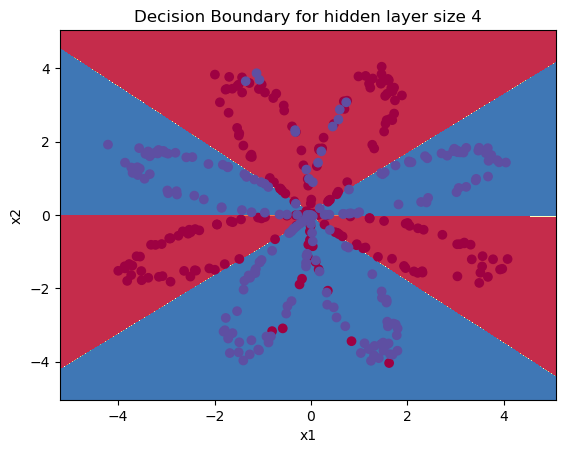

In [12]:
plot_decision_boundary(lambda x: predict1(binary_parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))
plt.show()

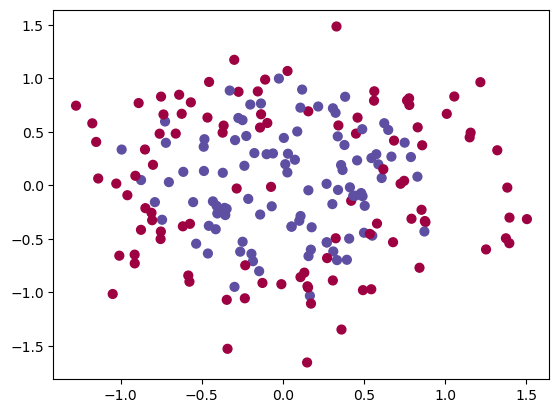

In [13]:
# Datasets
'''
Rerun the cells above after selecting a datasets and running this cell
'''

noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

### START CODE HERE ### (choose your dataset)
dataset = "noisy_circles"
### END CODE HERE ###

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);
plt.show()

# Binary Image Classification (Cats vs Not Cats)

In [14]:
train_dataset = h5py.File('datasets/train_catvnoncat.h5')
train_x_orig = np.array(train_dataset["train_set_x"][:])
train_y = np.array(train_dataset["train_set_y"][:])
train_y = train_y.reshape(1, -1)

test_dataset = h5py.File('datasets/test_catvnoncat.h5')
test_x_orig = np.array(test_dataset["test_set_x"][:])
test_y = np.array(test_dataset["test_set_y"][:])
test_y = test_y.reshape(1, -1)

classes = np.array(test_dataset["list_classes"][:])

train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1)
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1)

train_x = train_x_flatten / 255
test_x = test_x_flatten / 255

xtr = train_x.T
xtt = test_x.T

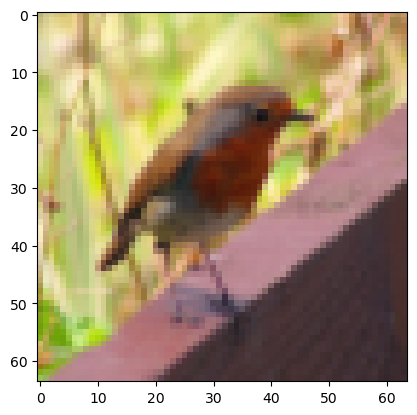

y = 0. It's a non-cat picture.


In [15]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
plt.show()
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [16]:
print ("train_x's shape: " + str(xtr.shape))
print ("test_x's shape: " + str(xtt.shape))
print ("train_y's shape: " + str(train_y.shape))
print ("test_y's shape: " + str(test_y.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)
train_y's shape: (1, 209)
test_y's shape: (1, 50)


In [17]:
image_classification_layers_dims = (xtr.shape[0], 20, 7, 5, 1)

In [18]:
def image_classification_model(X, Y, layers_dims, optimizer="gd", learning_rate = 0.0007, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 5000, print_cost = False, decay=None, decay_rate=1):

    np.random.seed(1)
    
    L = len(layers_dims)             
    costs = []                       
    t = 0                            
    m = X.shape[1]                  
    lr_rates = []
    learning_rate0 = learning_rate
    
    parameters = initialize_parameters_xavier(layers_dims)

    if optimizer != "momentum" and optimizer != "adam":
        pass 
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)

    
    for i in range(num_epochs):
        al, caches = forward_propagation(X, parameters)
        cost_avg = compute_cost_log_loss(al, Y)
        grads = backward_propagation(X, Y, caches)

    
        if optimizer != "momentum" and optimizer != "adam":
            parameters = update_parameters(parameters, grads, learning_rate)
        elif optimizer == "momentum":
            parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
        elif optimizer == "adam":
            t = t + 1 # Adam counter
            parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s,
                                                           t, learning_rate, beta1, beta2,  epsilon)

            
        if decay:
            learning_rate = decay(learning_rate0, i, decay_rate)
       
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
            if decay:
                print("learning rate after epoch %i: %f"%(i, learning_rate))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
                
    # # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("model Learning rate = " + str(learning_rate))
    plt.show()

    # Parameters for prediction and grads for gradient checking
    return parameters, grads

Cost after epoch 0: 0.771749
Cost after epoch 1000: 0.315187
Cost after epoch 2000: 0.113821
Cost after epoch 2499: 0.088440


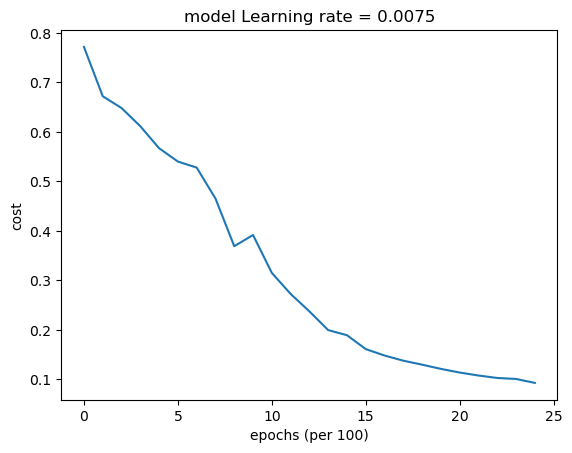

In [19]:
image_classification_parameters, gradients = model(xtr, train_y, image_classification_layers_dims, learning_rate=0.0075, num_epochs = 2500, print_cost=True, init="xavier", seed=1, check_gradient=False)

In [20]:
predictions_train = predict(xtr, train_y, image_classification_parameters)

Accuracy: 0.9856459330143539


In [21]:
predictions_test = predict(xtt, test_y, image_classification_parameters)

Accuracy: 0.8


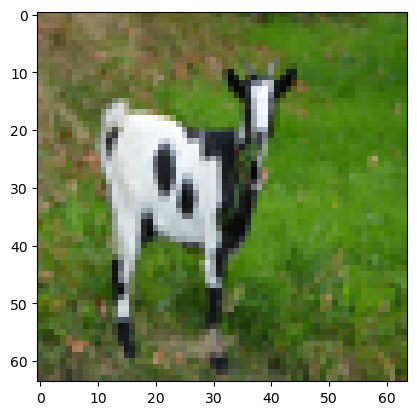

y = 0.0, your L-layer model predicts a "non-cat" picture.


In [22]:
my_image = "goat-2775034_960_720-3704390797.jpg"
my_label_y = [1] 


num_px = 64
fname = my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
plt.show()
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T

my_predicted_image = predict(image, my_label_y, image_classification_parameters, print_accuracy=False)


print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

# Teting Different Parameter Initializations

In [23]:
np.random.seed(1)
train_x1, train_y1 = sklearn.datasets.make_circles(n_samples=300, noise=0.05)
np.random.seed(2)
test_x1, test_y1 = sklearn.datasets.make_circles(n_samples=100, noise=0.05)

train_x1 = train_x1.T
test_x1 = test_x1.T

train_y1 = train_y1.reshape(1, -1)
test_y1 = test_y1.reshape(1, -1)

In [24]:
init_param_layers_dims = [train_x1.shape[0], 10, 5, 1]

In [25]:
def initialize_parameters_model(X, Y, layers_dims, optimizer="gd", learning_rate = 0.0007, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 5000, print_cost = False, decay=None, decay_rate=1 ,init="random"):

    np.random.seed(1)
    
    L = len(layers_dims)             
    costs = []                       
    t = 0                            
    m = X.shape[1]                  
    lr_rates = []
    learning_rate0 = learning_rate
    
    
    if init == "zeros":
        parameters = {}
        L = len(layers_dims)
    
        for l in range(1, L):
            parameters["W"+str(l)] = np.zeros((layers_dims[l], layers_dims[l-1]))
            parameters["b"+str(l)] = np.zeros((layers_dims[l],1))
    
    if init == "random":
        np.random.seed(3)
        parameters = {}
        L = len(layers_dims)
    
        for l in range(1, L):
            parameters["W"+str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) *10
            parameters["b"+str(l)] = np.zeros((layers_dims[l],1))

    if init == "he":
        parameters = initialize_parameters_he(layers_dims)

    
    if optimizer != "momentum" and optimizer != "adam":
        pass 
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)

    
    for i in range(num_epochs):
        al, caches = forward_propagation(X, parameters)
        cost_avg = compute_cost_log_loss(al, Y)
        grads = backward_propagation(X, Y, caches)

    
        if optimizer != "momentum" and optimizer != "adam":
            parameters = update_parameters(parameters, grads, learning_rate)
        elif optimizer == "momentum":
            parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
        elif optimizer == "adam":
            t = t + 1 # Adam counter
            parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s,
                                                           t, learning_rate, beta1, beta2,  epsilon)

            
        if decay:
            learning_rate = decay(learning_rate0, i, decay_rate)
       
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
            if decay:
                print("learning rate after epoch %i: %f"%(i, learning_rate))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
                
    # # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("model Learning rate = " + str(learning_rate))
    plt.show()

    # Parameters for prediction and grads for gradient checking
    return parameters, grads

Gradient check difference: 0.004033675959343756
Cost after epoch 0: 0.691730
Gradient check difference: 0.01933898486118488
Cost after epoch 1000: 0.683302
Gradient check difference: 0.0030225005975263526
Cost after epoch 2000: 0.679163
Gradient check difference: 0.028518197092852672
Cost after epoch 3000: 0.672792
Gradient check difference: 0.00018453527105109687
Cost after epoch 4000: 0.661357
Gradient check difference: 0.0002076613676727187
Cost after epoch 5000: 0.640712
Gradient check difference: 0.00027840159783927825
Cost after epoch 6000: 0.606761
Gradient check difference: 0.008393831365336285
Cost after epoch 7000: 0.550066
Gradient check difference: 0.00023896005058627096
Cost after epoch 8000: 0.482570
Gradient check difference: 0.024388862550316255
Cost after epoch 9000: 0.410804
Gradient check difference: 0.0008599600046602534
Cost after epoch 10000: 0.342050
Gradient check difference: 0.05175089274079308
Cost after epoch 11000: 0.277970
Gradient check difference: 0.01643

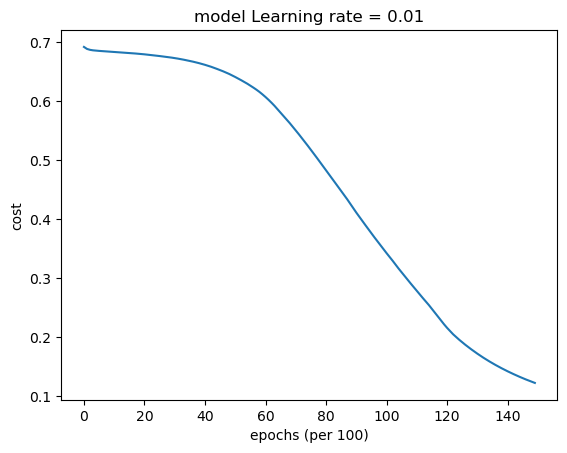

On the train set:
Accuracy: 0.9900000000000002
On the test set:
Accuracy: 0.94


In [26]:
xavier_parameters, gradientss = model(train_x1, train_y1, init_param_layers_dims, init = "xavier", learning_rate=0.01, num_epochs=15000, print_cost=True, check_gradient=True)
print ("On the train set:")
predictions_train = predict(train_x1, train_y1, xavier_parameters)
print ("On the test set:")
predictions_test = predict(test_x1, test_y1, xavier_parameters)

# Testing Regularization 

In [27]:
data = scipy.io.loadmat("datasets/data.mat")
train_x2 = data["X"].T
train_y2 = data["y"].T
test_x2 = data["Xval"].T
test_y2 = data["yval"].T

In [28]:
regularization_model_layers_dim = [train_x2.shape[0], 20, 3, 1]

In [29]:
def reg_model(X, Y, layers_dims, 
                        optimizer="gd", learning_rate = 0.0007, num_epochs = 5000,
                        momentum_beta = 0.9, adam_beta1 = 0.9, adam_beta2 = 0.999,  epsilon = 1e-8,
                        init="random", hidden_activation="relu", output_activation="sigmoid",
                        lambd=0, keep_probs=1,
                        decay=None, decay_rate=1, 
                        print_cost = False, seed=None):

    assert(lambd ==0 or keep_probs==1)

    
    L = len(layers_dims)             
    costs = []                       
    t = 0                            
    m = X.shape[1]                  
    lr_rates = []
    learning_rate0 = learning_rate
    
    
    
    if init == "random":
        parameters = initialize_parameters(layers_dims, seed)
    elif init == "he":
        parameters = initialize_parameters_he(layers_dims, seed)
    elif init == "xavier":
        parameters = initialize_parameters_xavier(layers_dims, seed)

    
    
    if optimizer != "momentum" and optimizer != "adam":
        pass 
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)

    
    
    for i in range(num_epochs):
        if keep_probs == 1:
            al, caches = forward_propagation(X, parameters, hidden_activation, output_activation)
        elif keep_probs < 1:
            al, caches = forward_propagation_with_dropout(X, parameters, hidden_activation, output_activation, keep_probs)
        
        if lambd == 0:
            cost_avg = compute_cost_log_loss(al, Y)
        elif lambd > 0:
            cost_avg = compute_cost_with_regularization(al, Y, parameters, lambd)

        if lambd >= 0 and keep_probs == 1:
            grads = backward_propagation(X, Y, caches, hidden_activation, lambd)
        elif keep_probs < 1:
            grads = backward_propagation_with_dropout(X, Y, caches, keep_probs, al, hidden_activation)
        

    
        if optimizer != "momentum" and optimizer != "adam":
            parameters = update_parameters(parameters, grads, learning_rate)
        elif optimizer == "momentum":
            parameters, v = update_parameters_with_momentum(parameters, grads, v, momentum_beta, learning_rate)
        elif optimizer == "adam":
            t = t + 1 # Adam counter
            parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s,
                                                           t, learning_rate, adam_beta1, adam_beta2,  epsilon)

            
        if decay:
            learning_rate = decay(learning_rate0, i, decay_rate)
       
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
            if decay:
                print("learning rate after epoch %i: %f"%(i, learning_rate))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
                
    # # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("model Learning rate = " + str(learning_rate))
    plt.show()

    # Parameters for prediction and grads for gradient checking
    return parameters, grads

#### Unregularized

Gradient check difference: 0.07991833690193025
Cost after epoch 0: 0.655741
Gradient check difference: 0.8805552782107713
Cost after epoch 1000: 0.222267
Gradient check difference: 0.9985691273896333
Cost after epoch 2000: 0.202887
Gradient check difference: 0.9989104268293936
Cost after epoch 3000: 0.182515
Gradient check difference: 0.9996712832788545
Cost after epoch 4000: 0.180540
Gradient check difference: 0.9995239300127025
Cost after epoch 5000: 0.176205
Gradient check difference: 0.9989620799982535
Cost after epoch 6000: 0.168327
Gradient check difference: 0.9990256386437817
Cost after epoch 7000: 0.165836
Gradient check difference: 0.9990774158887112
Cost after epoch 8000: 0.163127
Gradient check difference: 0.9963818941156917
Cost after epoch 9000: 0.159426
Gradient check difference: 0.9981985790599107
Cost after epoch 10000: 0.163300
Gradient check difference: 0.9963151551689965
Cost after epoch 11000: 0.160986
Gradient check difference: 0.996675647840121
Cost after epoch 12

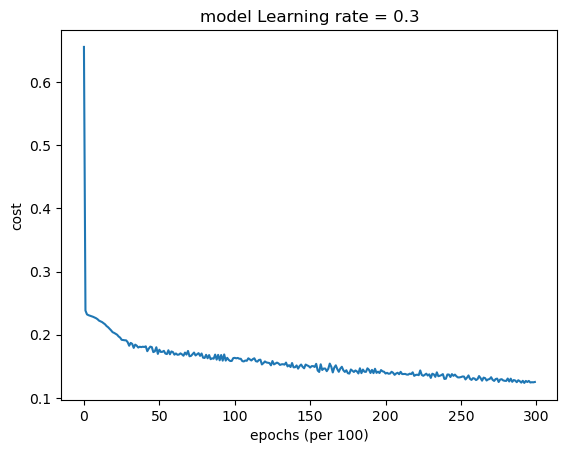

On the training set:
Accuracy: 0.9478672985781991
On the test set:
Accuracy: 0.9149999999999998


In [30]:
unreg_parameters, gradients = model(train_x2, train_y2, regularization_model_layers_dim, learning_rate=0.3, num_epochs=30000, print_cost=True, init="xavier", seed=3, check_gradient=True)
print ("On the training set:")
predictions_train = predict(train_x2, train_y2, unreg_parameters)
print ("On the test set:")
predictions_test = predict(test_x2, test_y2, unreg_parameters)

#### Regularized

Gradient check difference: 0.10065363603016157
Cost after epoch 0: 0.697448
Gradient check difference: 0.7815939290215926
Cost after epoch 1000: 0.273046
Gradient check difference: 0.9891835515240512
Cost after epoch 2000: 0.269858
Gradient check difference: 0.9961489764966845
Cost after epoch 3000: 0.269508
Gradient check difference: 0.9967634665802465
Cost after epoch 4000: 0.269265
Gradient check difference: 0.9968411766894588
Cost after epoch 5000: 0.269043
Gradient check difference: 0.9966885336395604
Cost after epoch 6000: 0.268897
Gradient check difference: 0.9967417251608336
Cost after epoch 7000: 0.268775
Gradient check difference: 0.9966171694497653
Cost after epoch 8000: 0.268673
Gradient check difference: 0.9962537566348872
Cost after epoch 9000: 0.268560
Gradient check difference: 0.9960946613471459
Cost after epoch 10000: 0.268492
Gradient check difference: 0.995652258734431
Cost after epoch 11000: 0.268414
Gradient check difference: 0.9955823425970152
Cost after epoch 12

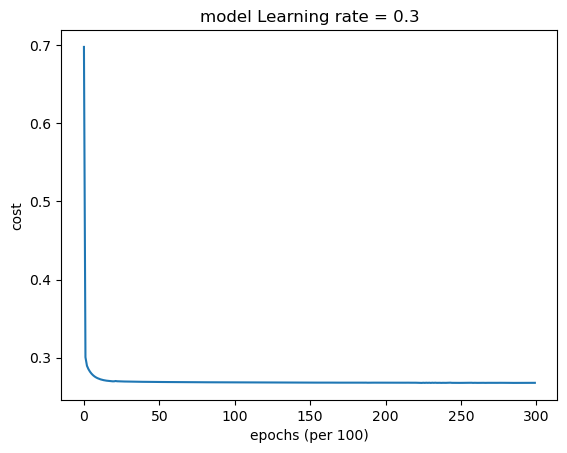

On the training set:
Accuracy: 0.9383886255924171
On the test set:
Accuracy: 0.9299999999999998


In [31]:
reg_parameters, gradients = model(train_x2, train_y2, regularization_model_layers_dim, lambd=0.7, learning_rate=0.3, num_epochs=30000, print_cost=True, init="xavier", seed=3, check_gradient=True)
print ("On the training set:")
predictions_train = predict(train_x2, train_y2, reg_parameters)
print ("On the test set:")
predictions_test = predict(test_x2, test_y2, reg_parameters)

#### Dropout

Gradient check difference: 0.08973195081725864
Cost after epoch 0: 0.657931
Gradient check difference: 0.6659513357847848
Cost after epoch 1000: 0.254177
Gradient check difference: 0.8175893949634668
Cost after epoch 2000: 0.238668
Gradient check difference: 0.8920435904721222
Cost after epoch 3000: 0.218268
Gradient check difference: 0.8315195638619453
Cost after epoch 4000: 0.179931
Gradient check difference: 0.7265988372304245
Cost after epoch 5000: 0.201060
Gradient check difference: 0.7476222634355199
Cost after epoch 6000: 0.181533
Gradient check difference: 0.871393751828988
Cost after epoch 7000: 0.210237
Gradient check difference: 0.8997797815083362
Cost after epoch 8000: 0.182911
Gradient check difference: 0.8636898187392008
Cost after epoch 9000: 0.193241
Gradient check difference: 0.44048775474742374
Cost after epoch 10000: 0.205327
Gradient check difference: 0.7323397267816897
Cost after epoch 11000: 0.162079
Gradient check difference: 0.8523743533736424
Cost after epoch 1

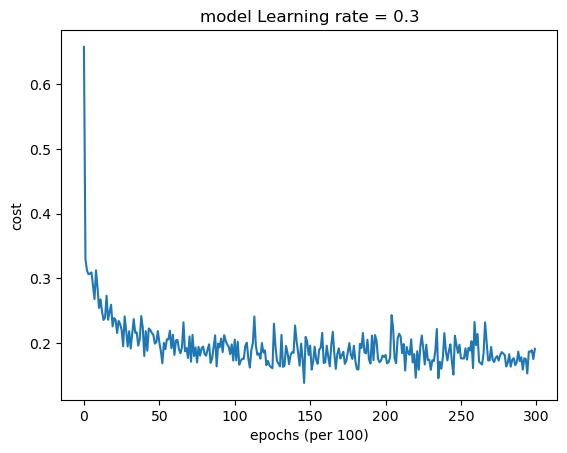

On the training set:
Accuracy: 0.9478672985781991
On the test set:
Accuracy: 0.9349999999999998


In [32]:
dropout_parameters, gradients = model(train_x2, train_y2, regularization_model_layers_dim, keep_probs=0.86, learning_rate=0.3, num_epochs=30000, print_cost=True, init="xavier", seed=3, check_gradient=True)
print ("On the training set:")
predictions_train = predict(train_x2, train_y2, dropout_parameters)
print ("On the test set:")
predictions_test = predict(test_x2, test_y2, dropout_parameters)

# Optimization Testing

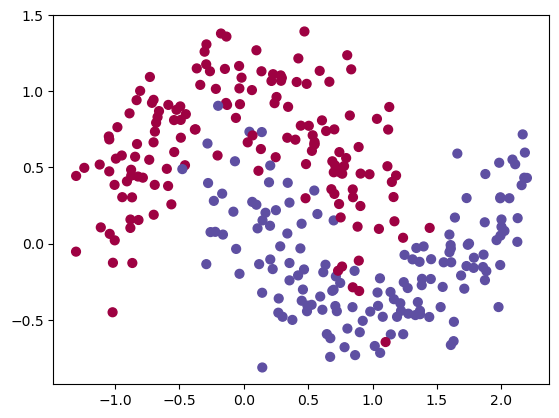

In [33]:
np.random.seed(3)
train_X3, train_Y3 = sklearn.datasets.make_moons(n_samples=300, noise=.2) #300 #0.2 
# Visualize the data
plt.scatter(train_X3[:, 0], train_X3[:, 1], c=train_Y3, s=40, cmap=plt.cm.Spectral);
plt.show()
train_X3 = train_X3.T
train_Y3 = train_Y3.reshape((1, train_Y3.shape[0]))

In [34]:
optimizing_layers_dims = [train_X3.shape[0], 5, 2, 1]

Gradient check difference: 0.20831169834151317
Cost after epoch 0: 0.702414
learning rate after epoch 0: 0.100000
Gradient check difference: 0.0029497823756334924
Cost after epoch 1000: 0.292998
learning rate after epoch 1000: 0.050000
Gradient check difference: 0.0023724921433074682
Cost after epoch 2000: 0.210913
learning rate after epoch 2000: 0.033333
Gradient check difference: 0.3726463533981749
Cost after epoch 3000: 0.157162
learning rate after epoch 3000: 0.025000
Gradient check difference: 0.00019900425205763908
Cost after epoch 4000: 0.148079
learning rate after epoch 4000: 0.020000
Gradient check difference: 0.0002961768575457565
Cost after epoch 4999: 0.144822
learning rate after epoch 4999: 0.020000


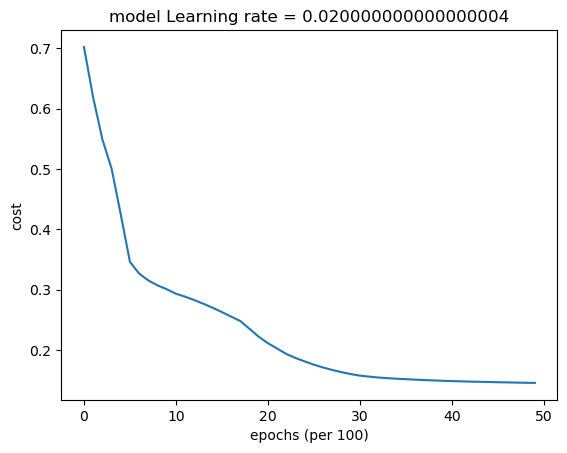

Accuracy: 0.9366666666666668


In [35]:
optimized_parameters, gradients = model(train_X3, train_Y3, optimizing_layers_dims, optimizer = "momentum", learning_rate = 0.1, num_epochs=5000, 
                              decay=schedule_lr_decay, print_cost=True, init="he", seed=3, check_gradient=True)

# Predict
predictions = predict(train_X3, train_Y3, optimized_parameters)

# Gradient Checking

#### Gradient Checking: Binary Classification with Tanh in a Single Hidden Layer NN

In [36]:
final_al, final_caches = forward_propagation(X, binary_parameters, hidden_activation="tanh", output_activation="sigmoid")

final_grads = backward_propagation(X, Y, final_caches, hidden_activation="tanh", lambd=0)

difference = gradient_checking(binary_parameters, final_grads, X, Y, print_msg=True, hidden_activation="tanh", output_activation="sigmoid")

print(f"Gradient check difference: {difference}")

There is a mistake in the backward propagation! difference = 1.2590635115068616e-06
Gradient check difference: 1.2590635115068616e-06


#### Gradient Checking: image classification Network

In [37]:
final_al, final_caches = forward_propagation(xtr[:,:1], image_classification_parameters, hidden_activation="relu", output_activation="sigmoid")

final_grads = backward_propagation(xtr[:,:1], train_y[:,:1], final_caches, hidden_activation="relu", lambd=0)

difference = gradient_checking(image_classification_parameters, final_grads, xtr[:,:1], train_y[:,:1], print_msg=True, hidden_activation="relu", output_activation="sigmoid")

print(f"Gradient check difference: {difference}")

Your backward propagation works perfectly fine! difference = 4.9149240293423095e-08
Gradient check difference: 4.9149240293423095e-08


#### Gradient Checking: Different Parameter Initializations

In [38]:
final_al, final_caches = forward_propagation(train_x1, xavier_parameters, hidden_activation="relu", output_activation="sigmoid")

final_grads = backward_propagation(train_x1, train_y1, final_caches, hidden_activation="relu", lambd=0)

difference = gradient_checking(xavier_parameters, final_grads, train_x1, train_y1, print_msg=True, hidden_activation="relu", output_activation="sigmoid")

print(f"Gradient check difference: {difference}")

Your backward propagation works perfectly fine! difference = 9.723346591136487e-09
Gradient check difference: 9.723346591136487e-09


#### Gradient Checking: Unregularized Network

In [39]:
final_al, final_caches = forward_propagation(train_x2, unreg_parameters, hidden_activation="relu", output_activation="sigmoid")

final_grads = backward_propagation(train_x2, train_y2, final_caches, hidden_activation="relu", lambd=0)

difference = gradient_checking(unreg_parameters, final_grads, train_x2, train_y2, print_msg=True, hidden_activation="relu", output_activation="sigmoid")

print(f"Gradient check difference: {difference}")

Your backward propagation works perfectly fine! difference = 1.1142675775942201e-09
Gradient check difference: 1.1142675775942201e-09


#### Gradient Checking: Regularized Network

In [40]:
final_al, final_caches = forward_propagation(train_x2, reg_parameters, hidden_activation="relu", output_activation="sigmoid")

final_grads = backward_propagation(train_x2, train_y2, final_caches, hidden_activation="relu", lambd=0)

difference = gradient_checking(reg_parameters, final_grads, train_x2, train_y2, print_msg=True, hidden_activation="relu", output_activation="sigmoid")

print(f"Gradient check difference: {difference}")

Your backward propagation works perfectly fine! difference = 7.894884253854643e-09
Gradient check difference: 7.894884253854643e-09


#### Gradient Checking: Dropout Network

In [41]:
final_al, final_caches = forward_propagation(train_x2, dropout_parameters, hidden_activation="relu", output_activation="sigmoid")

final_grads = backward_propagation(train_x2, train_y2, final_caches, hidden_activation="relu", lambd=0)

difference = gradient_checking(dropout_parameters, final_grads, train_x2, train_y2, print_msg=True, hidden_activation="relu", output_activation="sigmoid")

print(f"Gradient check difference: {difference}")

Your backward propagation works perfectly fine! difference = 4.124804527904102e-09
Gradient check difference: 4.124804527904102e-09


#### #### Gradient Checking: Different Optimization

In [42]:
final_al, final_caches = forward_propagation(train_X3, optimized_parameters, hidden_activation="relu", output_activation="sigmoid")

final_grads = backward_propagation(train_X3, train_Y3, final_caches, hidden_activation="relu", lambd=0)

difference = gradient_checking(optimized_parameters, final_grads, train_X3, train_Y3, print_msg=True, hidden_activation="relu", output_activation="sigmoid")

print(f"Gradient check difference: {difference}")

Your backward propagation works perfectly fine! difference = 2.345467783816375e-08
Gradient check difference: 2.345467783816375e-08
